# Multiple Linear Regression
## Housing Case Study

#### Problem Statement:

Consider a real estate company that has a dataset containing the prices of properties in the Delhi region. It wishes to use the data to optimise the sale prices of the properties based on important factors such as area, bedrooms, parking, etc.

Essentially, the company wants —


- To identify the variables affecting house prices, e.g. area, number of rooms, bathrooms, etc.

- To create a linear model that quantitatively relates house prices with variables such as number of rooms, area, number of bathrooms, etc.

- To know the accuracy of the model, i.e. how well these variables can predict house prices.

**So interpretation is important!**

## Import Dependencies

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load dataset and analyse

In [11]:
housing = pd.read_csv('Housing.csv')
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [12]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
price               545 non-null int64
area                545 non-null int64
bedrooms            545 non-null int64
bathrooms           545 non-null int64
stories             545 non-null int64
mainroad            545 non-null object
guestroom           545 non-null object
basement            545 non-null object
hotwaterheating     545 non-null object
airconditioning     545 non-null object
parking             545 non-null int64
prefarea            545 non-null object
furnishingstatus    545 non-null object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [13]:
housing.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


## 2. Visualising the data

### 2.1. Visualise scatter plots among all numeric variables

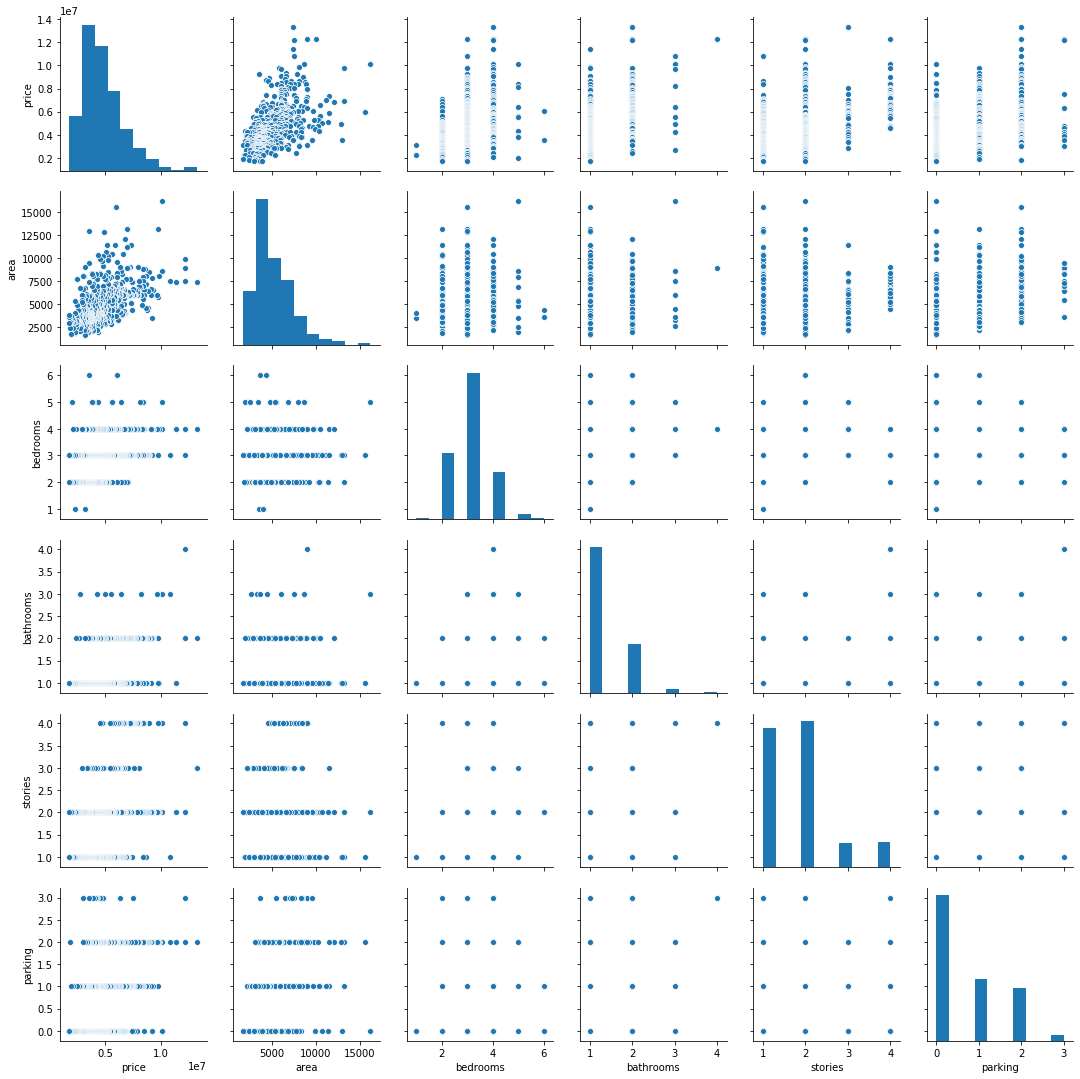

In [14]:
sns.pairplot(housing)
plt.show()

### 2.2. Visualising sprea of price against the categorical variables

In [21]:
cat_vars = ['mainroad', 'guestroom', 'basement', 
            'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

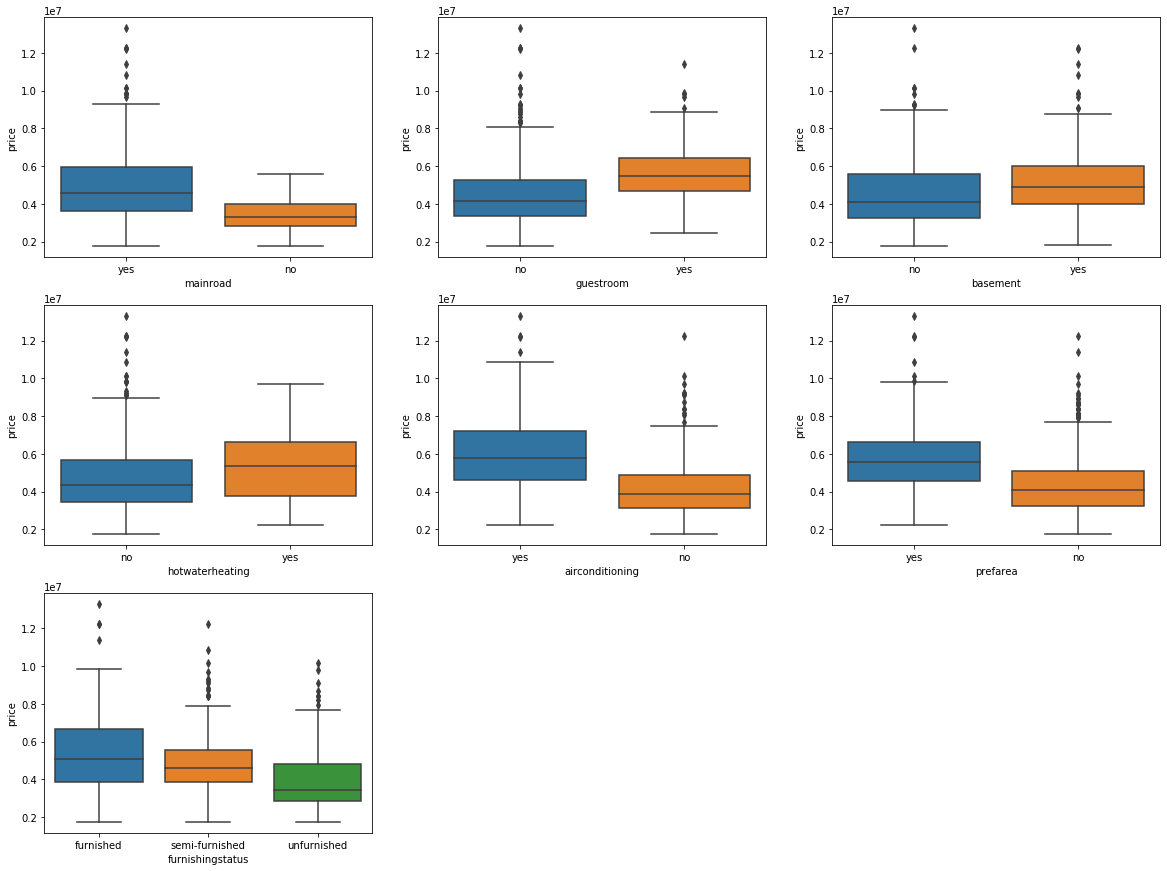

In [26]:
fig_width = 20
fig_height = 15
plt.figure(figsize=[fig_width,fig_height])

for index, cat_var in enumerate(cat_vars):
    plt.subplot(3,3,index + 1)
    sns.boxplot(x=cat_var, y='price', data=housing)

## 2. Data preprocessing

### 2.1. Convert binary features to numeric
- ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

In [5]:
def binary_to_numerical(column):
    '''
    Given a binary column, maps 'yes' to 1 and 'no' to 0
    '''
    return column.apply(lambda x: 1 if x=='yes' else 0)

In [6]:
# Apply binary_to_numerical to all binary columns
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
housing[binary_columns] = housing[binary_columns].apply(binary_to_numerical)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


### 2.2 Convert categorical variables to one hot encoding
- Observed that `furnishingstatus` is a categorical variable which could potentially have more than 2 levels 

In [7]:
# Find out unique levels in the furnishingstatus column
housing['furnishingstatus'].unique()

array(['furnished', 'semi-furnished', 'unfurnished'], dtype=object)

In [8]:
# Demo of what get_dummies do to a categorical column
pd.get_dummies(housing['furnishingstatus']).head()

,furnished,semi-furnished,unfurnished
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


In [9]:
# Now lets use get_dummies and drop one column and append it to the housing dataframe
status = pd.get_dummies(housing['furnishingstatus'], drop_first=True)
housing = pd.concat([housing, status], axis=1)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [52]:
# Now we can drop furnishingstatus as we have dummies for it.
housing = housing.drop(columns=['furnishingstatus'])
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0
